In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("..")

In [34]:
from src.data_generator import *
from src.model import *
import numpy as np
import matplotlib.pyplot as plt

Generate the training data, initially consider a very simple case of constant volatility, to use as a benchmark to test the methods.

In [5]:
X = SemiMartingale(X_0=1.0, vol=2.0)
x = X.generate(100000, 100)

First train a model using a method of moments. We try to match the first $k$ moments of the distribution generated by 
$$
Z_F = \frac{X_1 - X_0}{\sqrt{F(X_0,X_{1/n},X_{2/n},\ldots,X_{(n-1)/n},X_1)}}
$$
to those of the standard normal. We set $k=4$ and train using the $L1$ norm. We use a simple feedforward neural network, and train for 10 epochs.

In [10]:
moment_loss = MomentLoss(degree=4, p_norm=1)
moment_model = FFNetwork(n_layers=4, h_dims=128, loss=moment_loss)

In [17]:
history = moment_model.train(x, num_epochs=10, batch_size=256, plotting=False, lr=0.001)

Plot the training loss

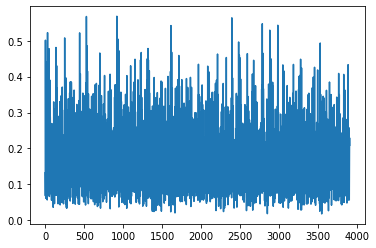

In [27]:
plt.plot(history['loss'])
plt.show()

Test the performance of the model. First generate a new batch of data, and check the distribution of the the model, and empirical scaled return, and compare against $N(0,1)$. 

In [19]:
x_test = X.generate(100000, 100)
iv = moment_model.predict_iv(x_test)

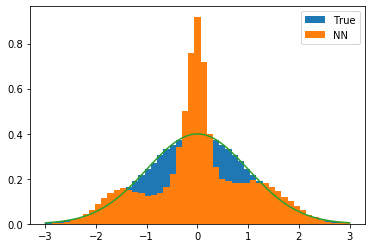

In [24]:
plot_hist(x_test, iv, X.get_norm_increments(), n_bins=50)

We can see that training with just four moments is not sufficient to capture the shape of the distribution. This is reflected in the output distribution of our IV estimates (recall that in this simple example the true vol and hence IV is just constant).

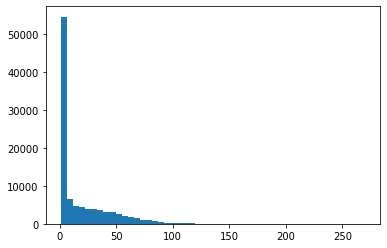

In [28]:
plt.hist(iv, bins=50)
plt.show()

In [29]:
print(f'Median estimate: {np.median(iv)}, Mean estimate: {np.mean(iv)}, std dev of estimates: {np.std(iv)}')

Median estimate: 4.932180167949003, Mean estimate: 18.574001846503087, std dev of estimates: 23.653199796846582


We could train for more epochs, with a larger network or with more moments but we use an alternative method, called maximal mean discrepency. This effectively gives us a way to match the two probability distributions through a kernelised representation of the data. In particular, MMD defines a weak (topology) on probability measures, with $MMD(\mathbb{P}, \mathbb{Q}) = 0$ iff $\mathbb{P} = \mathbb{Q}$ 

In [35]:
mmd_loss = MMDLoss()
mmd_model = FFNetwork(n_layers=4, h_dims=128, loss=mmd_loss)

In [36]:
history = mmd_model.train(x, num_epochs=10, batch_size=256, plotting=False, lr=0.001)

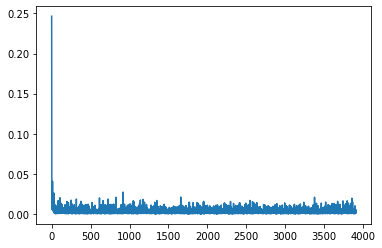

In [38]:
plt.plot(history['loss'])
plt.show()

In [40]:
x_test = X.generate(100000, 100)
iv = mmd_model.predict_iv(x_test)

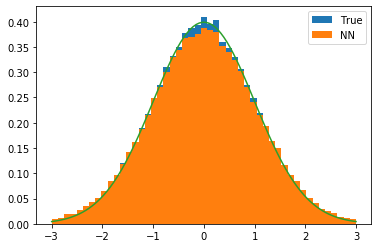

In [41]:
plot_hist(x_test, iv, X.get_norm_increments(), n_bins=50)

Here we can see that the MMD model is able to reproduce the distribution completely, with the exact same architecture and training time. However, it is not in actually necessarily identifying the correct IV to do this:

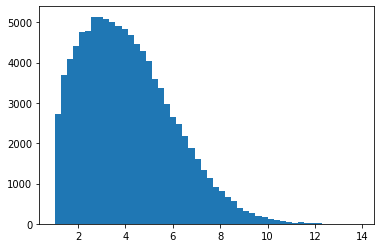

In [42]:
plt.hist(iv, bins=50)
plt.show()

In [43]:
print(f'Median estimate: {np.median(iv)}, Mean estimate: {np.mean(iv)}, std dev of estimates: {np.std(iv)}')

Median estimate: 3.8460681868512117, Mean estimate: 4.088848847138588, std dev of estimates: 1.9261652193077567


We see that the model learns a distribution of IV around the correct value, but not actually the correct value uniquely. It seems highly unlikely (from experiments and further training) that this learned IV distribution would further significantly converge since the model is already able to reproduce the asymptotic ditribution to a high degree.

In [44]:
from scipy.stats import kstest

In [46]:
model_z = mmd_model.predict_z(x_test)
kstest(model_z, 'norm')

KstestResult(statistic=0.012562399804904367, pvalue=3.921839134821887e-14)

We see that from a KS test, the generated sample is indistinguishible from a standard normal. So why then are we not learning the true volatility? The reason is that all this method (not MMD specifically but targeting the asymptotic distribution) does is ensure that probability mass is distributed in the correct way, but it doesn't force pointwise convergence. So for example, consider the plot of the model $Z_F$ against the true $Z$ from the data:

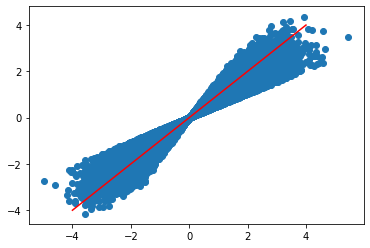

In [50]:
plt.scatter(model_z, X.get_norm_increments())
plt.plot((-4,4),(-4,4), color='red')
plt.show()

If the method were to uniquely recover the IV, we would expect all these points to lie on the line $y=x$, but just requiring the distributions to match is not sufficient to uniquely specify the IV - there is still some flexibility in how the mass is moved around while still acheiving the target distribution.